# Collect MusicLab recordings into device files
having now discovered several complications to the initial strategy for concatonating the minute long recordings of mobile accelerometer and gyroscope data, this new notebook should process the files efficiently from end to end.

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Some essential functions

In [7]:
def appfileconcat(folder,file_suffix):
    # function to concatonate the one minute mobile sensor time series in files generated by MusicLab (0.0.17)
    #   files must be within a single folder, share a common suffix, that alphabetised file names ensures 
    #   chronological order (i.e. these files have submission IDs prepended), be immidiately readable by pandas read_csv
    #   (top row: column names, following rows only samples) and include a column titled "time" with device-consistent 
    #   timestampe values that continue accross files and in the same units as gap_t
    # This function uses libraries: os, pandas as pd, and local definition nannotime
    #
    # This function does not add nans in gaps, so interpolators beware. Pass any extracted file through gap_nans before resampling.
    #
    # Inputs:
    #   folder: string, relative path to the folder with the files to concatonate
    #   file_suffix: string, ending of file names for files to concatenate. ex: '.csv', 'deviceMotion.csv'
    #   inst_data: pandas dataframe containing all the samples across files, with inserted np.nan, in chronological order

    inst_data = pd.DataFrame()

    filenames = os.listdir(folder)
    filenames.sort() # files are processed in order set by sample index
    f_Count = 0
    # print(len(filenames))
    for fn in filenames:
        if fn.endswith(file_suffix):
        # if not begining, check for overlap
            if len(inst_data)>0:
                last_ts = inst_data.timestamp.max()
                tr = pd.read_csv(folder + '/' + fn)
                if tr.timestamp.min()<inst_data.timestamp.max():
                    tr = tr.loc[tr.timestamp>inst_data.timestamp.max(),:]
                    inst_data = pd.concat([inst_data,tr],ignore_index=True)
                else:
                    # add the files data to inst_data    
                    inst_data = pd.concat([inst_data,tr],ignore_index=True)
            else: 
                inst_data = pd.read_csv(folder + '/' + fn)
            f_Count +=1
    print( folder + ', ' + str(f_Count)) 
            
    cols = inst_data.columns
#     if 'time' in cols:
#         inst_data = inst_data.sort_values('time',ignore_index=True)
#         print('Time sorted')
#     else:
    inst_data = inst_data.sort_values('timestamp',ignore_index=True)
#         print('Timestamp sorted')
    # deal with the instances where time is not a monotonic sequence ??>?>?>?>
    if 'time' in inst_data.columns:
        if inst_data['time'].diff().min()<0:
            # replace time with floats 
            inst_data['time'] = inst_data['timestamp'] - inst_data.loc[0,'timestamp'] + inst_data.loc[0,'time']
        
    return inst_data

In [8]:
def nannotime(row,shift,dshift):
    # function to generate a row of nans with caveats for time fields, which are shifted by a designated ammount 
    r = row.copy()
    cols = r.index
    for c in cols:
        if not c.startswith('time'):
            if not c.startswith('datetime'):
                r[c] = np.nan
            if c.startswith('datetime'):
                r[c] = r[c] + dshift  
        if c.startswith('time'):
            r[c] = r[c] + shift     
    return r

def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    
    data = data.append(nannotime(data.iloc[-1,:],deltat,dtdeltat),ignore_index=True)
    
    dt = data[time_col].diff()
    a = list(dt[dt>gap_t].index)
    a.sort(reverse=True)
    for gapi in a:
        data = data.append(nannotime(data.iloc[gapi-1,:],deltat,dtdeltat))
        data = data.append(nannotime(data.iloc[gapi,:],-deltat,dtdeltat))

    data = data.append(nannotime(data.iloc[0,:],-1,dtdeltat)).sort_values(time_col,ignore_index=True)
    return data

## test reading files from a single device
The MusicLab app generates uniquely named folders for each minute long recording of mobile sensors submitted to nettskjema. These have been downloaded and reorganised to have files for each device renamed and gathered into device specific folders, each named according to the installation ID randomly assigned to each device. (This ID string is unique but not identifying outside the musiclab app.) 

Details of this extraction process, from access the files via the Nettskjema API to reorganising them for more conveninent analysis, can be found in the repo https://github.com/finn42/PullingNettskjema

In [9]:
# windows machine data path
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall'
instIDs = os.listdir(data_path)

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/cc1ce8ab-eee9-f8fe-177e-6c9721798373, 134


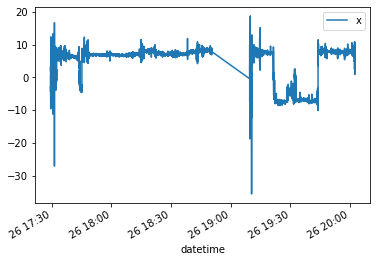

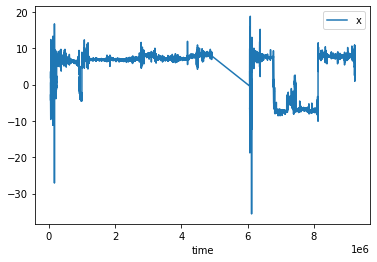

,timestamp,time,x,y,z,alpha,beta,gamma,datetime
0,1635269365754,56398.7,1.9,5.2,8.3,3.2,-5.2,7.2,2021-10-26 17:29:25.754
1,1635269365790,56434.7,2.2,5.2,7.8,-0.1,-7.5,1.9,2021-10-26 17:29:25.790
2,1635269365832,56476.7,2.2,5.2,8.0,-1.2,1.2,2.7,2021-10-26 17:29:25.832
3,1635269365860,56504.7,1.9,5.2,8.1,6.0,8.2,-0.3,2021-10-26 17:29:25.860
4,1635269365919,56563.7,1.8,5.4,7.5,5.7,-4.1,-10.2,2021-10-26 17:29:25.919
...,...,...,...,...,...,...,...,...,...
469495,1635278547469,9238113.7,7.1,0.6,6.5,-2.3,0.8,-1.0,2021-10-26 20:02:27.469
469496,1635278547485,9238129.7,7.3,0.6,6.0,-1.5,3.7,-2.4,2021-10-26 20:02:27.485
469497,1635278547503,9238147.7,6.9,0.6,5.9,8.5,11.1,-2.7,2021-10-26 20:02:27.503
469498,1635278547536,9238180.7,6.9,0.9,6.5,23.9,-6.6,-1.2,2021-10-26 20:02:27.536


In [10]:
# test reading a file
instid = "cc1ce8ab-eee9-f8fe-177e-6c9721798373"

folder = data_path + '/' + instid
file_suffix = 'deviceMotion.csv'
gap_t = 2000 # ms

# this function concatonates the dozens or hundreds of minute long recordings into single dataframe. It does this without 
inst_d = appfileconcat(folder,file_suffix) 
inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))

# testing the 
inst_d.plot.line(x='datetime',y='x')
plt.show()
inst_d.plot.line(x='time',y='x')
plt.show()
inst_d

## run through remote data set

In [6]:
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote'
output_folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Remote'
devices = os.listdir(data_path)

In [7]:
file_suffix = 'deviceMotion.csv'
for instid in devices:
    if len(instid)>10: # clearly an installation ID, not another folder
        folder = data_path + '/' + instid
        gap_t = 500 # ms 
        inst_d = appfileconcat(folder,file_suffix) 
        inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))
        
        # a = part_trail_pull(inst_d,Start_time,End_time)
        inst_d.to_csv(output_folder + '/deviceMotion/' + instid + '.Full_Concert.' + file_suffix, index = False)

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/05d05a78-b18c-0928-cbf7-b5b1b9600e55, 161
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/06fad321-8a49-062e-1e84-26704be216b8, 242
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/08ff9d8a-6bc2-897f-24d3-91eb10717741, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/090eb70c-5cc5-89d6-8f6c-14b2fdf7ab24, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/09d8163d-80e7-fda3-6919-6a3febc78e27, 194
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/0af15a6c-6a42-89cf-9092-96de2a2553a5, 4
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/10550c8a-ad24-2550-6344-a0f8b85a4739, 66
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobil

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/d7e89756-ada2-aed6-b3f7-716160c42fb9, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/da8d357f-81d2-ead7-8de2-ae423b1b167e, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/dba584ca-6587-4bc1-5165-4cf8e39eaaed, 4
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/ddfec0ee-dcc2-db2c-0de2-a22dfe78c044, 173
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/e630b096-5209-2a39-be53-e70d5042c429, 87
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/e6a57ce9-75de-1817-c8bb-87d42bea2a55, 171
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Remote/ed274608-acbc-93a7-4aee-459c763ff762, 62
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile

In [26]:
devices = os.listdir(data_path)
file_suffix = 'geoLocation.csv'
geod = 0

for instid in devices:
    if len(instid)>10: # clearly an installation ID, not another folder
        folder = data_path + '/' + instid
        file_suffix = 'geoLocation.csv'
        files = os.listdir(folder)
        if any(file_suffix in x for x in files):
            inst_d = appfileconcat(folder,file_suffix) 
            # Reduce to minutes for anonymyzation
            inst_d['latitude'] = np.round(inst_d['latitude'])
            inst_d['longitude'] = np.round(inst_d['longitude'])
            inst_d = inst_d.drop(['accuracy'],axis=1)
            inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))
            inst_d.to_csv(output_folder + '/' + instid + '.Full_Concert.' + file_suffix, index = False)
            geod += 1
            
geod

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/005093c6-7880-8728-1256-26822f05cfb0, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01393de0-e72e-5e80-f06f-8fdb5d0080cb, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01d00c32-d4dc-8ce6-353c-43143401adf3, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/03fcbb15-14c6-b806-80b8-e2c161654dd6, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/053bd8a0-2ed7-46e9-c088-8eaea2448192, 147
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/0ab9bf2b-a0c7-f823-0fde-6295eedb207e, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/195bb6e0-55ec-d521-d69e-7bfa7cf86b9a, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_Musi

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/f045e08d-53b9-5e26-ad38-107564d919bc, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/f20847af-4c00-639e-5484-d705bd7a3437, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/f6437dd9-96b3-7bce-42ef-4f01a6bfde18, 143
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/f9945bf5-e47a-a404-3f45-d6954e78ce2a, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/fe0534f2-aaad-2afb-f5ba-79f8c2cc98b2, 1


69

## run through hall data

In [27]:
data_path = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall'
output_folder = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Hall'
devices = os.listdir(data_path)

In [28]:
file_suffix = 'deviceMotion.csv'
for instid in devices:
    if len(instid)>10: # clearly an installation ID, not another folder
        folder = data_path + '/' + instid
        gap_t = 500 # ms 
        inst_d = appfileconcat(folder,file_suffix) 
        inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))
        
        # a = part_trail_pull(inst_d,Start_time,End_time)
        inst_d.to_csv(output_folder + '/deviceMotion/' + instid + '.Full_Concert.' + file_suffix, index = False)

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/005093c6-7880-8728-1256-26822f05cfb0, 255
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01393de0-e72e-5e80-f06f-8fdb5d0080cb, 140
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01d00c32-d4dc-8ce6-353c-43143401adf3, 147
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/03fcbb15-14c6-b806-80b8-e2c161654dd6, 94
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/04e20480-91d3-cd85-3470-8656b157978f, 138
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/053bd8a0-2ed7-46e9-c088-8eaea2448192, 150
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/0ab9bf2b-a0c7-f823-0fde-6295eedb207e, 122
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/C

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/b71de359-9d19-b08d-ba92-85005358b1b9, 76
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/b75d0d85-7d79-3483-f0c5-890a1bf93e43, 18
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/bfc2274e-acb2-21af-16d5-6ae9fac1593e, 142
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/c32d3e7d-8ee6-0a11-b056-cb501edbfc7e, 127
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/cc1ce8ab-eee9-f8fe-177e-6c9721798373, 134
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/cd1ae6f8-b8cf-4a62-48a2-ff2590e4e4df, 72
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/cf163fcc-b07d-4b8c-09c2-bb67dfa35767, 113
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Con

In [29]:
devices = os.listdir(data_path)
file_suffix = 'geoLocation.csv'
geod = 0

for instid in devices:
    if len(instid)>10: # clearly an installation ID, not another folder
        folder = data_path + '/' + instid
        files = os.listdir(folder)
        if any(file_suffix in x for x in files):
            inst_d = appfileconcat(folder,file_suffix) 
            # Reduce to minutes for anonymyzation
            inst_d['latitude'] = np.round(inst_d['latitude'])
            inst_d['longitude'] = np.round(inst_d['longitude'])
            inst_d = inst_d.drop(['accuracy'],axis=1)
            inst_d['datetime']=(pd.to_datetime(inst_d['timestamp'],unit='ms'))
            inst_d.to_csv(output_folder + '/' + instid + '.Full_Concert.' + file_suffix, index = False)
            geod += 1
            
geod

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/005093c6-7880-8728-1256-26822f05cfb0, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01393de0-e72e-5e80-f06f-8fdb5d0080cb, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/01d00c32-d4dc-8ce6-353c-43143401adf3, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/03fcbb15-14c6-b806-80b8-e2c161654dd6, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/053bd8a0-2ed7-46e9-c088-8eaea2448192, 147
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/0ab9bf2b-a0c7-f823-0fde-6295eedb207e, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/195bb6e0-55ec-d521-d69e-7bfa7cf86b9a, 3
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_Musi

C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/f6437dd9-96b3-7bce-42ef-4f01a6bfde18, 143
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/f9945bf5-e47a-a404-3f45-d6954e78ce2a, 1
C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Hall/fe0534f2-aaad-2afb-f5ba-79f8c2cc98b2, 1


69

# Check on alignment of data, without correction

In [31]:
# set the sampling period for the concert in UTC 
Start_time = '2021-10-26 17:30:00+0000'
End_time = '2021-10-26 20:30:00+0000'
# set standard timestamps in date time and millisecond floats. Datetime for ploting, ms for interp
# 10 Hz
ts_dt = pd.date_range(pd.to_datetime(Start_time), pd.to_datetime(End_time), freq='100ms')
ts_ts = np.arange(pd.to_datetime(Start_time).timestamp(), pd.to_datetime(End_time).timestamp(), 0.1)*1000

In [32]:
# folder of devicewise files for a specific set
folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Hall/deviceMotion/'
devices = os.listdir(folder)

# prime dataframe and constants
aud_df = pd.DataFrame(index = ts_ts)
dev_n = 0
kept_dev = []
gap_t = 5000 # 5 seconds
file_suffix = 'deviceMotion.csv'

In [33]:
# gather the raw recordings for the live performance
for devFile in devices:
    if devFile.endswith(file_suffix): # clearly an installation ID, not another folder
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
        
        datas = gap_nans(data,gap_t)
        datas['datetime'] = (pd.to_datetime(datas['timestamp'],unit='ms'))
        
        resampled = pd.DataFrame(index = ts_dt[:-1])
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ts)
            
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

aud_df.index = ts_dt[:-1]

hall_df = aud_df.copy()

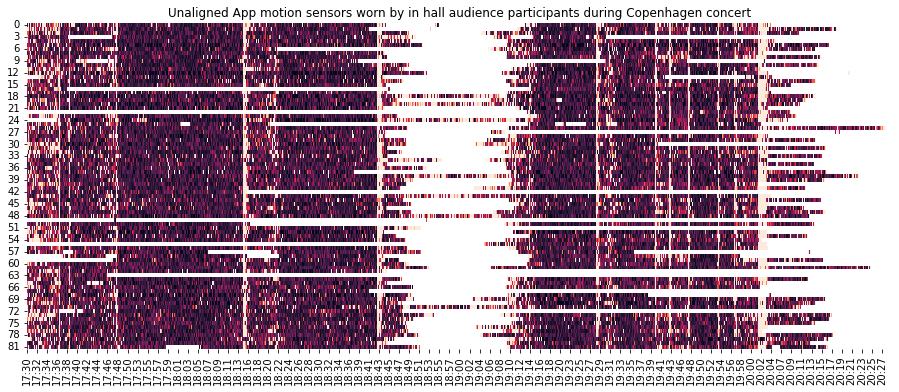

In [34]:
# plot for perspective
fig, ax = plt.subplots(figsize = [15.5,6])
chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(aud_df)/len(ax.get_xticks())))
ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Unaligned App motion sensors worn by in hall audience participants during Copenhagen concert')
plt.savefig('CoverageSnapshot_Copenhagen_Hall_raw.png')
plt.show()

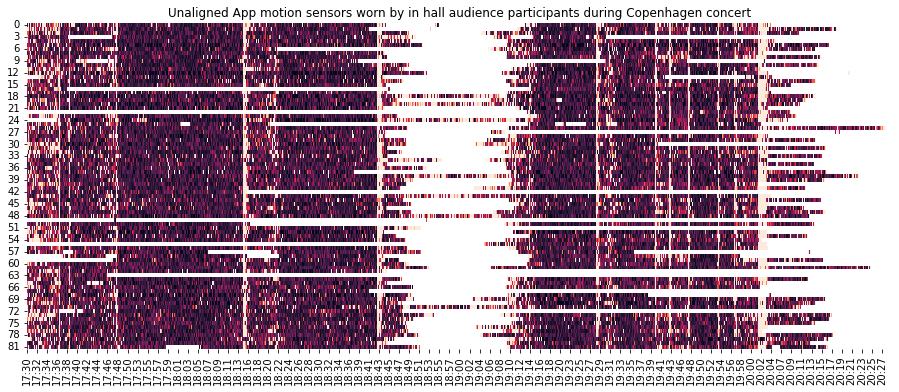

In [34]:
# TODO Make plot that zooms in so we can see the alignment quality

fig, ax = plt.subplots(figsize = [15.5,6])
chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(aud_df)/len(ax.get_xticks())))
ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Unaligned App motion sensors worn by in hall audience participants during Copenhagen concert')
plt.savefig('CoverageSnapshot_Copenhagen_Hall_raw.png')
plt.show()

In [35]:
# folder of devicewise files for a specific set
folder ='C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/Concert_MusicLab/Stitched_App_Sensors/Remote/deviceMotion/'
devices = os.listdir(folder)

# prime dataframe and constants
aud_df = pd.DataFrame(index = ts_ts)
dev_n = 0
kept_dev = []
gap_t = 5000 # 5 seconds
file_suffix = 'deviceMotion.csv'

In [36]:
# gather the raw recordings for the live performance
for devFile in devices:
    if devFile.endswith(file_suffix): # clearly an installation ID, not another folder
        data = pd.read_csv(folder + '/' + devFile)
        data['datetime'] = (pd.to_datetime(data['timestamp'],unit='ms'))
        datas = gap_nans(data,gap_t)
        datas['datetime'] = (pd.to_datetime(datas['timestamp'],unit='ms'))
        
        resampled = pd.DataFrame(index = ts_dt[:-1])
        cols = datas.columns
        for col in cols[1:]:
            f = interpolate.interp1d(datas['timestamp'], datas[col],fill_value='extrapolate')
            resampled[col] = f(ts_ts)
            
        b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
        if np.nanmedian(b)>0:
            aud_df[dev_n] = b/np.nanmedian(b)
        else:
            aud_df[dev_n] = b/np.nanmean(b)
        dev_n+=1
        kept_dev.append(devFile)

aud_df.index = ts_dt[:-1]

rem_df = aud_df.copy()

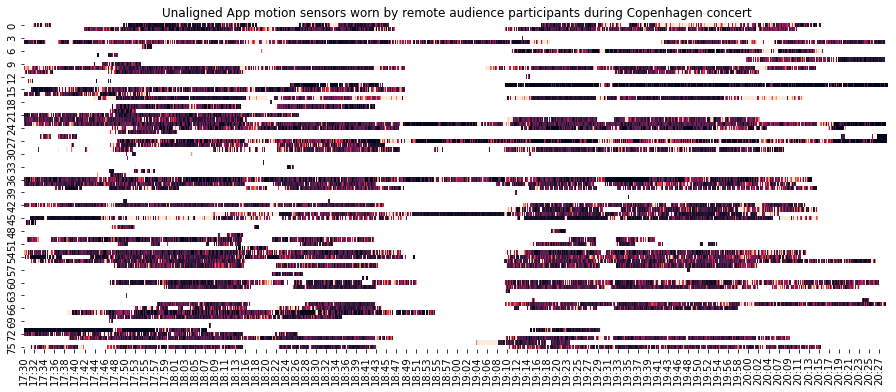

In [37]:
# plot for perspective
fig, ax = plt.subplots(figsize = [15.5,6])
chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(aud_df)/len(ax.get_xticks())))
ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Unaligned App motion sensors worn by remote audience participants during Copenhagen concert')
plt.savefig('CoverageSnapshot_Copenhagen_Remote_raw.png')
plt.show()

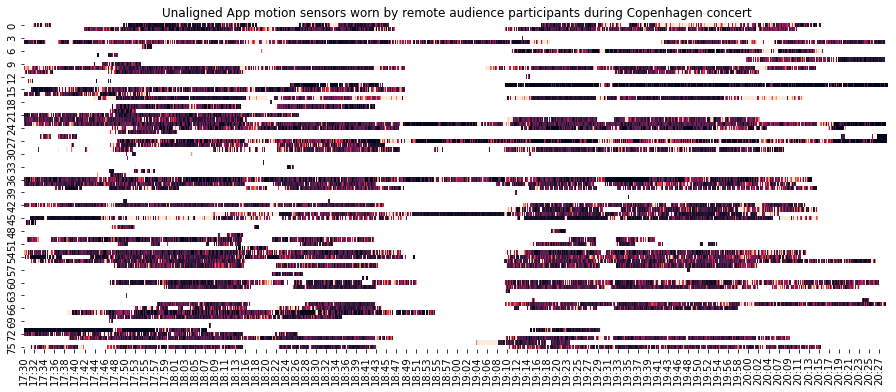

In [37]:
# TODO Make plot that zooms in so we can see the alignment quality

fig, ax = plt.subplots(figsize = [15.5,6])
chart = sns.heatmap(data=aud_df.transpose(), ax=ax,vmin=0, vmax=5,cbar=False)

freq = int(round(len(aud_df)/len(ax.get_xticks())))
ax.set_xticklabels(aud_df.iloc[::freq].index.strftime("%H:%M"))
plt.title('Unaligned App motion sensors worn by remote audience participants during Copenhagen concert')
plt.savefig('CoverageSnapshot_Copenhagen_Remote_raw.png')
plt.show()